In [1]:
import os
from glob import glob

import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.utils.data as data
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import cv2

import numpy as np
from PIL import Image

# Hyperparameter

In [2]:
print('Num_GPU :', torch.cuda.device_count())

no_cuda = False
use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
Tensor = torch.cuda.FloatTensor if use_cuda else torch.Tensor

params = {
    'batch_size':50 * torch.cuda.device_count(),
    'test_batch_size':50 * torch.cuda.device_count(),
    'input_size':256,
    'resize_scale':310,
    'crop_size':256,
    'fliplr':True,
    'threshold':0.5,
    #model params
    'ngf':64,
    'ndf':64,
    'epoch_count':1,
    'epochs':300,
    'log_interval':4,
    'lr':0.0002,
    'dataroot':'C:/Users/IVCL/Desktop/crane',
}

Num_GPU : 2


# Utils

In [3]:
def to_np(x):
    return x.data.cpu().numpy()
        
def plot_train_result(test_image, epoch, save=False,  show=True, fig_size=(8, 8)):
    plt.figure(figsize=fig_size)
    imgs = [to_np(test_image[0]), to_np(test_image[1]), to_np(test_image[2])]
    title = ["Test Image", "Test Mask", "Predicted Mask"]
        
    plt.subplot(1, 3, 1)
    plt.title(title[0])
    img = imgs[0]
    img = img.squeeze()
    img = (((img - img.min()) * 255) / (img.max() - img.min())).transpose(1, 2, 0).astype(np.uint8)
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title(title[1])
    img = imgs[1]
    img = img.squeeze()
    img = (((img - img.min()) * 255) / (img.max() - img.min()))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title(title[2])
    img = imgs[2]
    img = img.squeeze()
    img = (((img - img.min()) * 255) / (img.max() - img.min()))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
    # save figure
    if save:
        save_fn = './img_per_epoch/epoch_{:d}'.format(epoch+1) + '.png'
        fig.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()

# Model

In [4]:
class Net(nn.Module):
    def __init__(self, d=64):
        super(Net,self).__init__()
        #f1
        self.conv1 = nn.Conv2d(3, d, 5, 2, 2)
        self.bn1 = nn.BatchNorm2d(d)
        self.relu1 = nn.LeakyReLU(inplace=True)

        self.conv2 = nn.Conv2d(3, d, 5, 2, 2)
        self.bn2 = nn.BatchNorm2d(d)
        self.relu2 = nn.LeakyReLU(inplace=True)
       
        #f2
        self.conv3 = nn.Conv2d(d*2, d*2, 5, 2, 2)
        self.bn3 = nn.BatchNorm2d(d*2)
        self.relu3 = nn.LeakyReLU(inplace=True)

        self.conv4 = nn.Conv2d(d*2, d*2, 5, 2, 2)
        self.bn4 = nn.BatchNorm2d(d*2)
        self.relu4 = nn.LeakyReLU(inplace=True)
       
        #f3
        self.conv5 = nn.Conv2d(d*4, d*2, 5, 2, 2)
        self.bn5 = nn.BatchNorm2d(d*2)
        self.relu5 = nn.LeakyReLU(inplace=True)

        self.conv6 = nn.Conv2d(d*4, d*2, 5, 2, 2)
        self.bn6 = nn.BatchNorm2d(d*2)
        self.relu6 = nn.LeakyReLU(inplace=True)
       
        #f4
        self.conv7 = nn.Conv2d(d*4, d*4, 5, 2, 2)
        self.bn7 = nn.BatchNorm2d(d*4)
        self.relu7 = nn.LeakyReLU(inplace=True)

        self.conv8 = nn.Conv2d(d*4, d*4, 5, 2, 2)
        self.bn8 = nn.BatchNorm2d(d*4)
        self.relu8 = nn.LeakyReLU(inplace=True)
       
        #encode
        self.fc1 = nn.Linear(int(params['input_size']/16)*int(params['input_size']/16)*d*8, d*4)
        self.fc2 = nn.Linear(d*4,int(params['input_size']/16)*int(params['input_size']/16)*d*4)
        
        #d1
        self.conv9 = nn.ConvTranspose2d(d*4, d*2, 5, 2, 2, 1)
        self.bn9 = nn.BatchNorm2d(d*2)
        self.relu9 = nn.LeakyReLU(inplace=True)
        
        #d1_uni
        self.conv10 = nn.ConvTranspose2d(d*4, d*4, 5, 1, 2)
        self.bn10 = nn.BatchNorm2d(d*4)
        self.relu10 = nn.LeakyReLU(inplace=True)
        
        #d2
        self.conv11 = nn.ConvTranspose2d(d*4, d*2, 5, 2, 2, 1)
        self.bn11 = nn.BatchNorm2d(d*2)
        self.relu11 = nn.LeakyReLU(inplace=True)       

        #d2_uni
        self.conv12 = nn.Conv2d(d*4, d*4, 5, 1, 2)
        self.bn12 = nn.BatchNorm2d(d*4)
        self.relu12 = nn.LeakyReLU(inplace=True)  

        #d3
        self.conv13 = nn.ConvTranspose2d(d*4, d, 5, 2, 2, 1)
        self.bn13 = nn.BatchNorm2d(d)
        self.relu13 = nn.LeakyReLU(inplace=True)          

        #d3_uni
        self.conv14 = nn.Conv2d(d*2, d*2, 5, 1, 2)
        self.bn14 = nn.BatchNorm2d(d*2)
        self.relu14 = nn.LeakyReLU(inplace=True) 
        
        #decode
        self.conv15 = nn.ConvTranspose2d(d*2, 1, 5, 2, 2, 1)
    
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
    
    def forward(self, x):
        f1_1 = self.relu1(self.bn1(self.conv1(x))) #64x64x64
        f1_2 = self.relu2(self.bn2(self.conv2(x))) #64x64x64
        
        f1 = torch.cat((f1_1, f1_2), 1) #128x64x64
        
        f2_1 = self.relu3(self.bn3(self.conv3(f1))) #128x32x32
        f2_2 = self.relu4(self.bn4(self.conv4(f1))) #128x32x32

        f2 = torch.cat((f2_1, f2_2), 1) #256x32x32
        
        f3_1 = self.relu5(self.bn5(self.conv5(f2))) #128x16x16
        f3_2 = self.relu6(self.bn6(self.conv6(f2))) #128x16x16
        
        f3 = torch.cat((f3_1, f3_2), 1) #256x16x16

        f4_1 = self.relu7(self.bn7(self.conv7(f3))) #256x8x8
        f4_2 = self.relu8(self.bn8(self.conv8(f3))) #256x8x8
        
        f4 = torch.cat((f4_1, f4_2), 1) #512x8x8

        x = f4.view(f4.size(0), -1)
        encode = self.fc1(x) #256
        
        d1 = self.fc2(encode) #256x8x8
        d1 = self.relu9(self.bn9(self.conv9(d1.view(-1,256,int(params['input_size']/16),int(params['input_size']/16))))) #128x16x16
             
        d1_uni = torch.cat((d1, f3_2), 1) #256x16x16
        d1_uni = self.relu10(self.bn10(self.conv10(d1_uni))) #256x16x16
        
        d2 = self.relu11(self.bn11(self.conv11(d1_uni))) #128x32x32
        
        d2_uni = torch.cat((d2, f2_2), 1) #256x32x32
        d2_uni = self.relu12(self.bn12(self.conv12(d2_uni))) #256x32x32
        
        d3 = self.relu13(self.bn13(self.conv13(d2_uni))) #64x64x64
        
        d3_uni = torch.cat((d3, f1_2), 1) #128x64x64
        d3_uni = self.relu14(self.bn14(self.conv14(d3_uni))) #128x64x64

        mask = self.conv15(d3_uni) #1x128x128
        
        return torch.sigmoid(mask)

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

# Preprocess

In [5]:
train_image_paths = glob(params['dataroot'] + '/image_coco_512_bbox_aug/*.png')
train_mask_paths = glob(params['dataroot'] + '/mask_coco_512_bbox/*.png')
    
test_image_paths = glob(params['dataroot'] + '/real_image/*.png')
test_mask_paths = glob(params['dataroot'] + '/real_mask/*.png')

In [6]:
class DatasetFromFolder(data.Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, resize_scale=None, crop_size=None, fliplr=False):
        super(DatasetFromFolder, self).__init__()
        self.image_path = image_dir
        self.mask_path = mask_dir
        
        self.transform = transform
        
        self.resize_scale = resize_scale
        self.crop_size = crop_size
        self.fliplr = fliplr

    def __getitem__(self, index):
        # Load Image
        img_fn = self.image_path[index]
        mask_fn = self.mask_path[index]
        
        img = Image.open(img_fn).convert('RGB')
        mask = Image.open(mask_fn)
        
        seed = random.randint(1, 1000)
        random.seed(seed)
                          
        # preprocessing
        if self.resize_scale:
            img = img.resize((self.resize_scale, self.resize_scale), Image.BILINEAR)
            mask = mask.resize((self.resize_scale, self.resize_scale), Image.BILINEAR)
            
        if self.crop_size:
            x = random.randint(0, self.resize_scale - self.crop_size + 1)
            y = random.randint(0, self.resize_scale - self.crop_size + 1)
            img = img.crop((x, y, x + self.crop_size, y + self.crop_size))
            mask = mask.crop((x, y, x + self.crop_size, y + self.crop_size))
            
        if self.fliplr:
            if random.random() < 0.5:
                img = img.transpose(Image.FLIP_LEFT_RIGHT)
                mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
        
        mask = np.array(mask)
        mask = np.where(mask>0,1.0,0)
        mask = torch.from_numpy(mask)
        mask = mask.unsqueeze_(0).float()  
        
        if self.transform is not None:
            img = self.transform(img)
        
        return img, mask

    def __len__(self):
        return len(self.image_path)

In [7]:
transform = transforms.Compose([
    transforms.Resize(size=(params['input_size'], params['input_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

train_data = DatasetFromFolder(train_image_paths, train_mask_paths, transform=transform,
                                resize_scale=params['resize_scale'], crop_size=params['crop_size'], fliplr=params['fliplr'])
train_data_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=params['batch_size'], shuffle=True)

test_data = DatasetFromFolder(test_image_paths, test_mask_paths, transform=transform,
                             resize_scale=params['input_size'])
test_data_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=params['test_batch_size'], shuffle=False)

In [8]:
for i, (data, mask) in enumerate(test_data_loader):
    if i == 0:
        print(data[0].shape, mask[0].shape)
        break

torch.Size([3, 256, 256]) torch.Size([1, 256, 256])


(-0.5, 255.5, 255.5, -0.5)

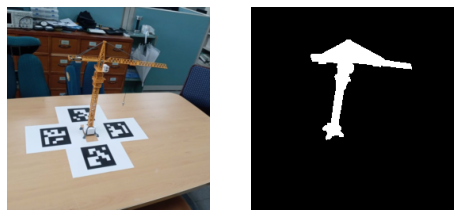

In [9]:
# Get specific test images
test_image, test_mask = test_data.__getitem__(15) # Convert to 4d tensor (BxNxHxW)
test_image = test_image.unsqueeze(0)

test_data_image = ((test_image - test_image.min()) / (test_image.max() - test_image.min()))

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(test_data_image[0].permute(1,2,0))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(test_mask[0],'gray')
plt.axis('off')

# Optimization

In [10]:
#shape invariant mean square error loss
def si_mse_loss(input, target):
    loss1 = ((input-target)**2).sum()/(input.view(-1).size()[0])
    loss2 = (((input-target).sum())**2)/((input.view(-1).size()[0])**2)
    loss = loss1 - loss2
    
    return loss
    
model = Net(params['ngf'])
model.weight_init(mean=0.0, std=0.02)
model = nn.DataParallel(model)
model.to(device)

# setup optimizer
optimizer = optim.Adam(model.parameters(), lr=params['lr'])

# Visualization

In [11]:
def visualization(model, test_path, mask_path):
    model.eval()
    model.to(device)
    transform = transforms.Compose([
            transforms.Resize(size=(params['input_size'], params['input_size'])),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])     

    image = Image.open(test_path).convert("RGB")
    image = transform(image).unsqueeze_(0)
    mask = model(image)

    mask = to_np(mask)
    mask = mask.squeeze()
    mask_out = np.where(mask>=params['threshold'], 1.0, 0)
    
    test_image = plt.imread(test_path)
    mask_image = plt.imread(mask_path)
    
    plt.figure(figsize=(10,10))
    display_list = [test_image, mask_image, mask_out]
    title = ['Input Image', 'Ground Truth(Mask)', 'Predicted Mask']
       
    plt.subplot(1, 3, 1)
    plt.title(title[0])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[0])
    plt.axis('off')
        
    plt.subplot(1, 3, 2)
    plt.title(title[1])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[1], 'gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title(title[2])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[2], 'gray')
    plt.axis('off')  
    plt.show()

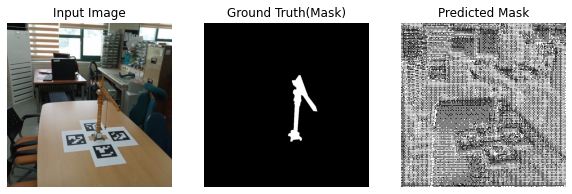

In [15]:
test_path = 'C:/Users/IVCL/Desktop/crane/real_image/creal_0065.png'
mask_path = 'C:/Users/IVCL/Desktop/crane/real_mask/creal_0065.png'
visualization(model, test_path, mask_path)

# Training

In [16]:
checkpoint_path = './checkpoints/seg_pix2pose'

In [ ]:
train_avg_mask_losses = []
val_avg_mask_losses = []

for epoch in range(params['epoch_count'], params['epochs'] + 1):
    # train
    model.to(device).train()
    cut_num = 20
    
    train_mask_losses = []
    val_mask_losses = []
    
    for iteration, (batch) in enumerate(train_data_loader):
        
        image, mask = batch[0].to(device), batch[1].to(device)
        pre_mask = model(image)

        optimizer.zero_grad()
 
        #mask loss
        loss_mask = F.binary_cross_entropy(pre_mask, mask)

        loss_mask.backward()
        optimizer.step()
        
        # loss values
        train_mask_losses.append(loss_mask.item())

        if iteration % params['log_interval'] == 0:
            print("===> Epoch[{}/{}]({}/{}): Loss_Mask: {:.4f}".format(
                epoch, params['epochs'],iteration, cut_num, loss_mask.item()))
        
        if iteration == cut_num:
            break
        
    # avg loss values for plot
    train_avg_mask_loss = torch.mean(torch.FloatTensor(train_mask_losses))   
    train_avg_mask_losses.append(train_avg_mask_loss.item())
    

    
    model.to(device).eval()
    
    with torch.no_grad():
        for iteration, (batch) in enumerate(test_data_loader):
            
            image, mask = batch[0].to(device), batch[1].to(device)
            pre_mask = model(image)

            #mask loss
            loss_mask = F.binary_cross_entropy(pre_mask, mask)

            val_mask_losses.append(loss_mask.item())
    
    # avg loss values for plot
    val_avg_mask_loss = torch.mean(torch.FloatTensor(val_mask_losses))
    val_avg_mask_losses.append(val_avg_mask_loss.item())
    
    print("Val_Loss_Mask: {:.4f}".format(val_avg_mask_loss.item()))
    
    # Show result for test image
    image = test_image.cuda()
    mask = test_mask.cuda()
    pre_mask = model(image)
    
    plot_train_result([image, mask, pre_mask], epoch, save=False)
    
    # Save weight
    if epoch % 1 == 0:
        torch.save(model.state_dict(), checkpoint_path+'/model-%s.pt'%epoch)

In [15]:
print('Mask Loss :',np.array(val_avg_mask_losses).argmin()+1)

Mask Loss : 238


# Loss Curve

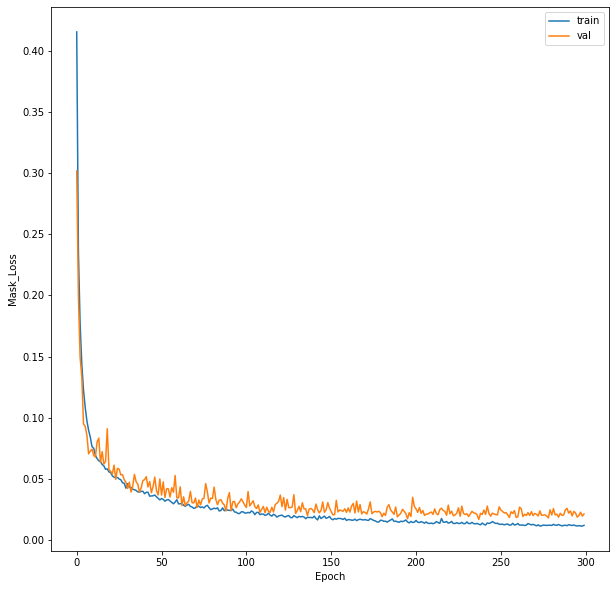

In [16]:
plt.figure(figsize=(10,10))
plt.plot(train_avg_mask_losses, label='train')
plt.plot(val_avg_mask_losses, label='val')
plt.xlabel('Epoch')
plt.ylabel('Mask_Loss')
plt.legend()

# Restore Checkpoint

In [17]:
weight_dict = torch.load(checkpoint_path+'/model-238.pt')

In [18]:
model.load_state_dict(weight_dict)

<All keys matched successfully>

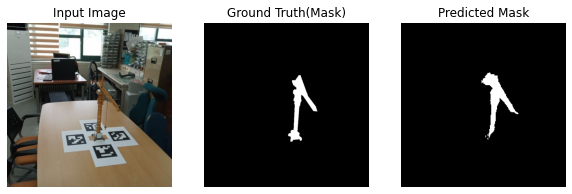

In [19]:
test_path = 'C:/Users/IVCL/Desktop/crane/real_image/creal_0065.png'
mask_path = 'C:/Users/IVCL/Desktop/crane/real_mask/creal_0065.png'
visualization(model, test_path, mask_path)

In [22]:
def precision(truth, pred):
    epsilon = 1e-7
    pred = pred.to('cpu').detach().numpy()
    truth = truth.to('cpu').detach().numpy()
    
    pred = np.where(pred >= params['threshold'], 1.0, 0)
    
    true_positive = np.sum(pred * truth)
    true_positive_false_positive = np.sum(pred)
    
    precision = true_positive / (true_positive_false_positive + epsilon)
                                 
    return precision

                                 
def recall(truth, pred):
    epsilon = 1e-7
    pred = pred.to('cpu').detach().numpy()
    truth = truth.to('cpu').detach().numpy()
    
    pred = np.where(pred >= params['threshold'], 1.0, 0)
    
    true_positive = np.sum(pred * truth)
    true_positive_false_negative =np.sum(truth)
    
    recall = true_positive / (true_positive_false_negative + epsilon)
                                 
    return recall

def accuracy(truth, pred):
    pred = pred.to('cpu').detach().numpy()
    truth = truth.to('cpu').detach().numpy()
    
    pred = np.where(pred >= params['threshold'], 1.0, 0)
    
    reversed_pred = 1 - pred
    reversed_truth = 1 - truth
    true_positive_true_negative = np.sum(pred * truth) + np.sum(reversed_pred * reversed_truth)
    
    accuracy = true_positive_true_negative / (np.sum(truth) + np.sum(reversed_truth))
                                 
    return accuracy

In [23]:
test_prec = 0
test_rec = 0
test_acc = 0
num_test = 0

model.to(device).eval()

for batch_idx, (data, mask_target) in enumerate(test_data_loader):
    data, mask_target = data.to(device), mask_target.to(device)
    mask_output = model(data)
    test_prec += precision(mask_target, mask_output)
    test_rec += recall(mask_target, mask_output)
    test_acc += accuracy(mask_target, mask_output)
    num_test += 1
    
print('test_precision :',100. * test_prec / num_test, '\ttest_recall :', 100. * test_rec / num_test, '\ttest_accuracy :', 100 * test_acc / num_test)

test_precision : 96.5513474324563 	test_recall : 89.93723201024551 	test_accuracy : 99.3463772446362
